In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [58]:
# Set random seeds for reproducibility
np.random.seed(11)
tf.random.set_seed(11)

In [59]:
# Load KDD99 dataset
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
print("Loading KDD99 dataset...")

# Column names for KDD99 dataset
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

# Load dataset (replace with your dataset path)
try:
    df = pd.read_csv('/content/drive/MyDrive/kddcup99_csv.csv', names=column_names, header=0)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Dataset file not found. Please download KDD99 dataset.")
    # For demonstration, create sample data structure
    df = pd.DataFrame(columns=column_names)


Loading KDD99 dataset...
Dataset loaded successfully. Shape: (494020, 42)


In [60]:
df['label'].unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

In [61]:
# Select relevant features for API gateway monitoring
# These features are most relevant for network traffic analysis in API context
relevant_features = [
    'duration',           # Connection duration
    'src_bytes',         # Bytes sent from source
    'dst_bytes',         # Bytes sent to destination
    'protocol_type'
    # 'count',             # Number of connections to same host
    # 'srv_count',         # Number of connections to same service

]

print(f"Selected {len(relevant_features)} relevant features for API gateway monitoring")


Selected 4 relevant features for API gateway monitoring


In [62]:
df['protocol_type'].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [63]:
# prompt: protocol type preprocess string to  int




In [64]:
def preprocess_data(df, features):
    """Preprocess the data for autoencoder training"""
    if df.empty:
        return None, None, None, None, None, None

    # Select relevant features
    X = df[features].copy()

    # Separate numeric and categorical columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Handle missing values differently for numeric and categorical
    for col in numeric_cols:
        X[col] = X[col].fillna(X[col].median())

    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'unknown')

    # Encode categorical features
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Create binary labels (normal vs anomaly)
    y = (df['label'] != 'normal').astype(int)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoders

In [65]:
if not df.empty:
    X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df, relevant_features)
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Normal samples in training: {sum(y_train == 0)}")
    print(f"Anomaly samples in training: {sum(y_train == 1)}")
else:
    # Create dummy data for demonstration
    n_features = len(relevant_features)
    X_train = np.random.normal(0, 1, (1000, n_features))
    X_test = np.random.normal(0, 1, (200, n_features))
    y_train = np.random.choice([0, 1], 1000, p=[0.8, 0.2])
    y_test = np.random.choice([0, 1], 200, p=[0.8, 0.2])
    scaler = StandardScaler().fit(X_train)
    label_encoders = {}

Training data shape: (395216, 4)
Test data shape: (98804, 4)
Normal samples in training: 77822
Anomaly samples in training: 317394


In [66]:
# Define Autoencoder Model
def create_autoencoder(input_dim, encoding_dim=2, hidden_dim=4):
    """Create autoencoder model optimized for API gateway deployment"""

    # Input layer
    input_layer = keras.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(hidden_dim, activation='relu')(input_layer)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(hidden_dim, activation='relu')(encoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)

    # Create model
    autoencoder = keras.Model(input_layer, decoded)
    encoder = keras.Model(input_layer, encoded)

    return autoencoder, encoder


In [67]:
# Create and compile model
input_dim = len(relevant_features)
autoencoder, encoder = create_autoencoder(input_dim)

autoencoder.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Autoencoder Model Architecture:")
autoencoder.summary()

Autoencoder Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62 (248.00 B)

 Trainable params: 62 (248.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Training configuration
EPOCHS = 50
BATCH_SIZE = 32

Training on 77822 normal samples...
Epoch 1/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.2050 - mae: 0.3152 - val_loss: 0.2927 - val_mae: 0.1531
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5464 - mae: 0.1606 - val_loss: 0.2246 - val_mae: 0.1326
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4728 - mae: 0.1508 - val_loss: 0.1987 - val_mae: 0.1343
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4567 - mae: 0.1685 - val_loss: 0.2442 - val_mae: 0.1738
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4191 - mae: 0.1922 - val_loss: 0.2564 - val_mae: 0.1860
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3753 - mae: 0.1957 - val_loss: 0.2663 - val_mae: 0.1859
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4169 - mae: 0.1971 - val_loss: 0.2719 - val_mae: 0.1865
Epoch 8/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4598 - mae: 0.1978 - val_loss: 0.2508 - val_mae: 0.1826

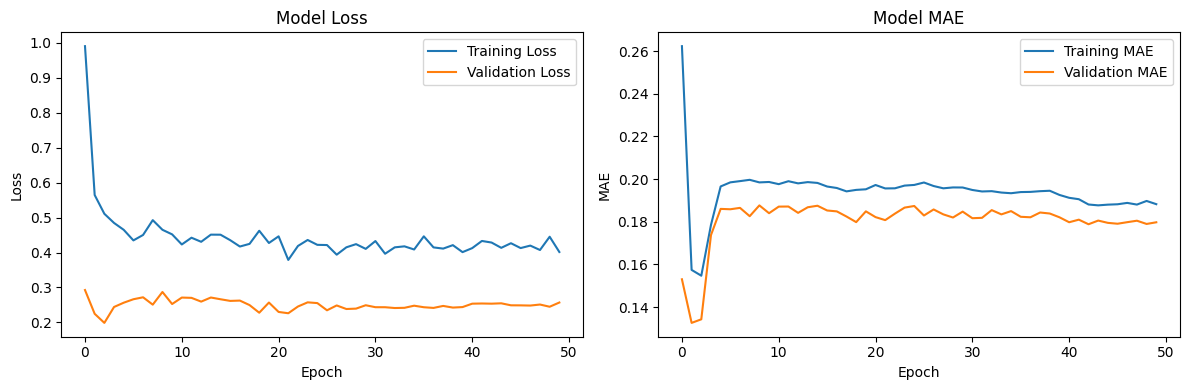

In [69]:
# Train only on normal data for anomaly detection
if not df.empty:
    # Filter normal samples for training
    normal_mask = y_train == 0
    X_train_normal = X_train[normal_mask]

    print(f"Training on {len(X_train_normal)} normal samples...")

    # Train the autoencoder
    history = autoencoder.fit(
        X_train_normal, X_train_normal,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        shuffle=True,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [70]:
# Evaluation and threshold determination
def calculate_reconstruction_error(model, X):
    """Calculate reconstruction error for anomaly detection"""
    predictions = model.predict(X, verbose=0)
    mse = np.mean(np.power(X - predictions, 2), axis=1)
    return mse

Anomaly detection threshold: 0.018209

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.19     19455
           1       0.82      1.00      0.90     79349

    accuracy                           0.82     98804
   macro avg       0.91      0.55      0.54     98804
weighted avg       0.86      0.82      0.76     98804



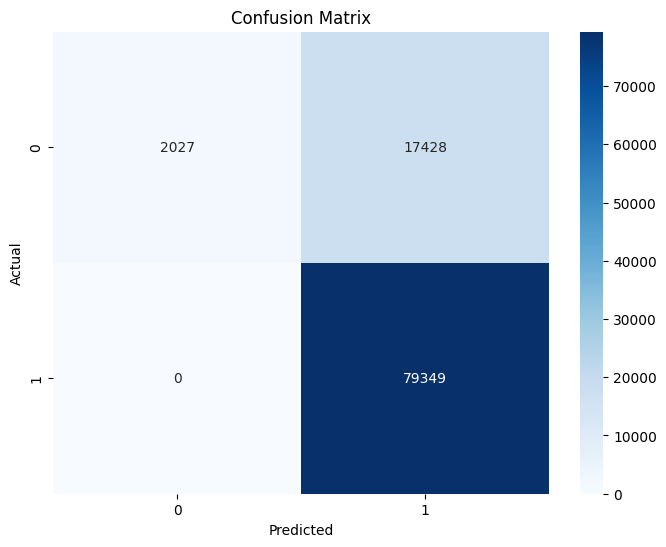

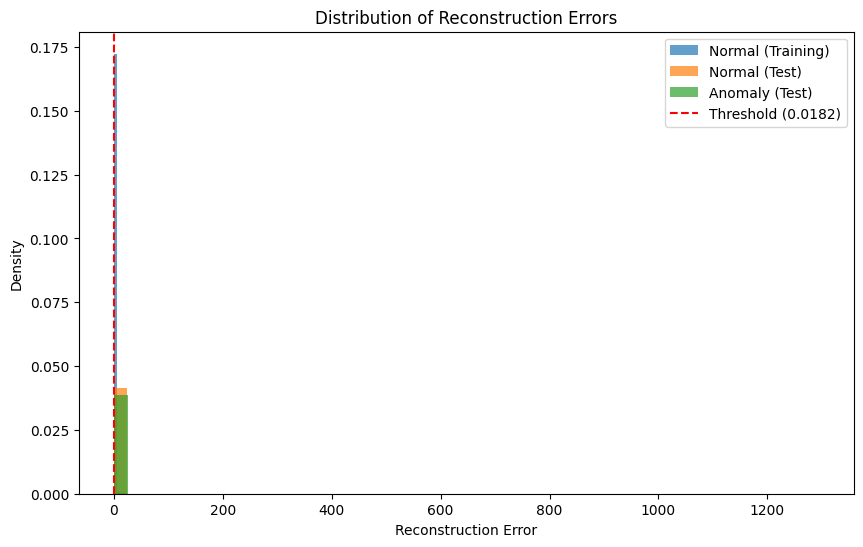

In [93]:
if not df.empty:
    # Calculate reconstruction errors
    train_errors = calculate_reconstruction_error(autoencoder, X_train)
    test_errors = calculate_reconstruction_error(autoencoder, X_test)

    # Determine threshold (95th percentile of normal training samples)
    normal_train_errors = train_errors[y_train == 0]
    threshold = np.percentile(normal_train_errors, 30)
    # threshold = 0.0185

    print(f"Anomaly detection threshold: {threshold:.6f}")

    # Make predictions
    y_pred = (test_errors > threshold).astype(int)

    # Evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(normal_train_errors, bins=50, alpha=0.7, label='Normal (Training)', density=True)
    plt.hist(test_errors[y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', density=True)
    plt.hist(test_errors[y_test == 1], bins=50, alpha=0.7, label='Anomaly (Test)', density=True)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()


In [94]:
def save_model_artifacts():
    """Save model and preprocessing components for API deployment"""

    # Save autoencoder model
    autoencoder.save('api_gateway_autoencoder.h5')
    print("Autoencoder model saved as 'api_gateway_autoencoder.h5'")

    # Save scaler
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler saved as 'feature_scaler.pkl'")

    # Save label encoders
    joblib.dump(label_encoders if not df.empty else {}, 'label_encoders.pkl')
    print("Label encoders saved as 'label_encoders.pkl'")

    # Save threshold and feature names
    model_config = {
        'threshold': threshold if not df.empty else 0.1,
        'feature_names': relevant_features,
        'input_dim': len(relevant_features)
    }

    joblib.dump(model_config, 'model_config.pkl')
    print("Model configuration saved as 'model_config.pkl'")

    return model_config

In [95]:
# Save artifacts
model_config = save_model_artifacts()

Autoencoder model saved as 'api_gateway_autoencoder.h5'
Feature scaler saved as 'feature_scaler.pkl'
Label encoders saved as 'label_encoders.pkl'
Model configuration saved as 'model_config.pkl'


In [96]:
def predict_anomaly(features_dict, model, scaler, threshold, feature_names, label_encoders=None):
    """
    Predict if a request is anomalous
    """
    try:
        # Extract features in correct order
        features = []
        for name in feature_names:
            value = features_dict.get(name, 0.0)

            # Handle categorical encoding
            if label_encoders and name in label_encoders:
                try:
                    value = label_encoders[name].transform([str(value)])[0]
                except:
                    value = 0  # Unknown category

            features.append(value)

        features = np.array(features).reshape(1, -1)

        # Scale features
        features_scaled = scaler.transform(features)

        # Calculate reconstruction error
        reconstructed = model.predict(features_scaled, verbose=0)
        error = np.mean(np.power(features_scaled - reconstructed, 2))

        # Determine if anomaly
        is_anomaly = error > threshold
        confidence = min(error / threshold, 5.0)

        return {
            'is_anomaly': bool(is_anomaly),
            'reconstruction_error': float(error),
            'threshold': float(threshold),
            'confidence_score': float(confidence),
            'status': 'anomaly' if is_anomaly else 'normal'
        }

    except Exception as e:
        return {
            'error': str(e),
            'status': 'error'
        }

In [97]:
# Normal traffic example
normal_request = {
    'duration': 0.5,
    'src_bytes': 1024,
    'dst_bytes': 2048,
    'protocol_type': 1
}

# DoS attack example
dos_attack = {
    'duration': 0.001,
    'src_bytes': 64,
    'dst_bytes': 0,
    'protocol_type': 1
}

# Port scan example
port_scan = {
    'duration': 0.01,
    'src_bytes': 40,
    'dst_bytes': 0,
    'protocol_type': 1
}

# Data exfiltration example
data_exfiltration = {
    'duration': 300.0,
    'src_bytes': 1024,
    'dst_bytes': 1048576,
    'protocol_type': 1
}

In [99]:
# Example usage
print("\n" + "="*60)
print("MODEL DEPLOYMENT READY")
print("="*60)
print(f"Features used: {len(relevant_features)}")
print(f"Model input dimension: {input_dim}")
if not df.empty:
    print(f"Anomaly threshold: {threshold:.6f}")
print("Files saved:")
print("- api_gateway_autoencoder.h5 (model)")
print("- feature_scaler.pkl (preprocessing)")
print("- model_config.pkl (configuration)")


if not df.empty:
    result = predict_anomaly(normal_request, autoencoder, scaler, threshold, relevant_features)
    print(f"\nSample prediction result: {result}")
    result = predict_anomaly(dos_attack, autoencoder, scaler, threshold, relevant_features)
    print(f"\nSample prediction result: {result}")
    result = predict_anomaly(port_scan, autoencoder, scaler, threshold, relevant_features)
    print(f"\nSample prediction result: {result}")
    result = predict_anomaly(data_exfiltration, autoencoder, scaler, threshold, relevant_features)
    print(f"\nSample prediction result: {result}")


MODEL DEPLOYMENT READY
Features used: 4
Model input dimension: 4
Anomaly threshold: 0.018209
Files saved:
- api_gateway_autoencoder.h5 (model)
- feature_scaler.pkl (preprocessing)
- model_config.pkl (configuration)

Sample prediction result: {'is_anomaly': False, 'reconstruction_error': 0.018161010472295177, 'threshold': 0.018209172275486532, 'confidence_score': 0.9973550800408324, 'status': 'normal'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Sample prediction result: {'is_anomaly': True, 'reconstruction_error': 0.018999151256593995, 'threshold': 0.018209172275486532, 'confidence_score': 1.0433835744511541, 'status': 'anomaly'}

Sample prediction result: {'is_anomaly': True, 'reconstruction_error': 0.018999127481710537, 'threshold': 0.018209172275486532, 'confidence_score': 1.0433822687968883, 'status': 'anomaly'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Sample prediction result: {'is_anomaly': True, 'reconstruction_error': 52.8294998853332, 'threshold': 0.018209172275486532, 'confidence_score': 5.0, 'status': 'anomaly'}
